In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
from scipy.interpolate import Rbf
from src.plot_utils import draw_pitch
from matplotlib import animation


#### Merging EPTS data and event data

- Match 1

In [2]:
df = pd.read_json('./Data/sample_match_1_with_v.json')
e_df = pd.read_json('./Data/sample_Game_1_events.json')

In [3]:
e_df.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,None,NaN,NaN,NaN,NaN
1,Away,PASS,None,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,None,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,None,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,None,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47


In [4]:
e_df['Start Frame'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1745 entries, 0 to 1744
Series name: Start Frame
Non-Null Count  Dtype
--------------  -----
1745 non-null   int64
dtypes: int64(1)
memory usage: 27.3 KB


In [5]:
df = df.merge(e_df.drop_duplicates(subset='Start Frame'), left_on='Frame', right_on='Start Frame', how='left') 

In [6]:
df.head()

,Period_x,Frame,Time [s],H11_x,H11_y,H1_x,H1_y,H2_x,H2_y,H3_x,...,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,1,1,0.04,0.08528,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,1.0,0.04,0.0,0.00,Player19,None,NaN,NaN,NaN,NaN
1,1,2,0.08,0.09984,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,0.12,0.11856,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,3.0,0.12,17.0,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,1,4,0.16,0.12584,32.80184,33.92688,44.41556,35.03448,33.31184,32.18176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,0.20,0.13416,32.80184,33.90088,44.38292,35.01056,33.33224,32.18592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
lis = df['Team'].to_list()
for i in range(len(lis)):
    if type(lis[0]) == float :
        lis[0] = 'Away'
    if type(lis[i]) == float :
        lis[i] = lis[i - 1]
df['Team'] = lis

#### Constructing the dataset

- p_kl : time(t), certain location, bal's location
- p_b  : time(t), ball's location
- d_kl : time(t), ball's location, sum of defensive team's influence function value at certain location

In [8]:
def influence_radius(ball, position):
    distance = np.linalg.norm(ball - position)
    output = np.minimum(3/200*(distance)**2 + 4, 10)
    return output

In [9]:
def influence_function2(position, locations, velocity, ball):
    mu = position + 0.5*velocity
    srat = (velocity[0]**2 + velocity[1]**2)/13**2
    theta = np.arctan(velocity[1]/(velocity[0]+1e-7))
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    R_inv = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])
    Ri = influence_radius(ball, position)
    S = np.array([[(1 + srat)*Ri/2, 0],[0, (1-srat)*Ri/2]])
    Cov = np.matmul(np.matmul(np.matmul(R, S), S), R_inv)
    new_gaussian = multivariate_normal(mu, Cov)
    out = new_gaussian.pdf(locations)
    out /= new_gaussian.pdf(position)
    return out

In [10]:
frame = 1000

In [11]:
t_df = df[df['Frame'] == frame].drop(['Period_x', 'Period_y', 'Ball_x', 'Ball_y', 'Ball_v_abs'], axis=1).iloc[0,:]

In [12]:
positions = t_df[[i for i in t_df.index if (('_x' in i) or ('_y' in i)) and 'v' not in i]]
positions.dropna(inplace=True)

In [13]:
velocities = t_df[[i for i in t_df.index if '_v' in i]]
velocities.dropna(inplace=True)

In [14]:
points = np.array([[positions[2*i], positions[2*i+1]] for i in range(len(positions)//2)])
velocities = np.array([[velocities[3*i], velocities[3*i+1]] for i in range(len(velocities)//3)])

In [15]:
players = np.array([positions.index[2*i].split('_')[0] for i in range(len(points))])
ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]

x, y = np.mgrid[0:104:2, 0:68:2]
locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

d_kl = 0
for i, j, k in zip(players, points, velocities):
    if t_df['Team'] == 'Away' :
        if 'H' in i:
            d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
    elif t_df['Team'] == 'Home':
        if 'A' in i:
            d_kl += influence_function2(j, locations, k, (ball_x, ball_y))


In [16]:
d_kl[d_kl>=1] = 1
v_kl = d_kl

In [17]:
tt_df = pd.DataFrame({'v_kl':v_kl, 'Ball_x':np.ones(len(d_kl))*ball_x, 'Ball_y':np.ones(len(d_kl))*ball_y, 'loc_x':locations[:,0], 'loc_y':locations[:,1]})

#### Function for constructing dataset

In [62]:
full_data = pd.DataFrame(columns = ['Ball_x', 'Ball_y', 'loc_x', 'loc_y', 'v_kl'])
full_data

,Ball_x,Ball_y,loc_x,loc_y,v_kl


In [64]:
with open('./Data/full_data2.csv', 'w') as csvfile:
    fieldnames = ['Ball_x', 'Ball_y', 'loc_x', 'loc_y', 'v_kl']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

In [68]:
df = df
fieldnames = ['Ball_x', 'Ball_y', 'loc_x', 'loc_y', 'v_kl']

for frame in np.arange(1, len(df['Frame']), 75):
    t_df = df[df['Frame'] == frame].drop(['Period_x', 'Period_y', 'Ball_x', 'Ball_y', 'Ball_v_abs'], axis=1).iloc[0,:]
    positions = t_df[[i for i in t_df.index if (('_x' in i) or ('_y' in i)) and 'v' not in i]]
    positions.dropna(inplace=True)
    velocities = t_df[[i for i in t_df.index if '_v' in i]]
    velocities.dropna(inplace=True)
    points = np.array([[positions[2*i], positions[2*i+1]] for i in range(len(positions)//2)])
    velocities = np.array([[velocities[3*i], velocities[3*i+1]] for i in range(len(velocities)//3)])
    if len(points) != 22 or len(velocities) != 22 :
        continue
    players = np.array([positions.index[2*i].split('_')[0] for i in range(len(points))])
    ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]
    if math.isnan(ball_x) :
        continue

    x, y = np.mgrid[0:104:5, 0:68:5]
    locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

    d_kl = 0
    for i, j, k in zip(players, points, velocities):
        if t_df['Team'] == 'Away' :
            if 'H' in i:
                d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
        elif t_df['Team'] == 'Home':
            if 'A' in i:
                d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
    
    d_kl[d_kl>=1] = 1
    v_kl = d_kl
    tt_df = pd.DataFrame({'v_kl':v_kl, 'Ball_x':np.ones(len(d_kl))*ball_x, 'Ball_y':np.ones(len(d_kl))*ball_y, 'loc_x':locations[:,0], 'loc_y':locations[:,1]})

    with open('./Data/full_data2.csv', 'a') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        for idx in range(len(tt_df)):
            writer.writerow(tt_df.loc[idx].to_dict())
                
    if frame%(100*75) == 1:
        print('\r ' + str(frame)+'/'+str(len(df)), end="")


In [330]:
df = pd.read_json('./Data/sample_match_2_with_v.json')
e_df = pd.read_json('./Data/sample_Game_2_events.json')

df = df.merge(e_df.drop_duplicates(subset='Start Frame'), left_on='Frame', right_on='Start Frame', how='left') 

lis = df['Team'].to_list()
for i in range(len(lis)):
    if type(lis[0]) == float :
        lis[0] = 'Away'
    if type(lis[i]) == float :
        lis[i] = lis[i - 1]
df['Team'] = lis


In [69]:
for frame in np.arange(1, len(df['Frame']), 75):
    t_df = df[df['Frame'] == frame].drop(['Period_x', 'Period_y', 'Ball_x', 'Ball_y', 'Ball_v_abs'], axis=1).iloc[0,:]
    positions = t_df[[i for i in t_df.index if (('_x' in i) or ('_y' in i)) and 'v' not in i]]
    positions.dropna(inplace=True)
    velocities = t_df[[i for i in t_df.index if '_v' in i]]
    velocities.dropna(inplace=True)
    points = np.array([[positions[2*i], positions[2*i+1]] for i in range(len(positions)//2)])
    velocities = np.array([[velocities[3*i], velocities[3*i+1]] for i in range(len(velocities)//3)])
    if len(points) != 22 or len(velocities) != 22 :
        continue
    players = np.array([positions.index[2*i].split('_')[0] for i in range(len(points))])
    ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]
    if math.isnan(ball_x) :
        continue

    x, y = np.mgrid[0:104:5, 0:68:5]
    locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

    d_kl = 0
    for i, j, k in zip(players, points, velocities):
        if t_df['Team'] == 'Away' :
            if 'H' in i:
                d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
        elif t_df['Team'] == 'Home':
            if 'A' in i:
                d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
    
    d_kl[d_kl>=1] = 1
    v_kl = d_kl
    tt_df = pd.DataFrame({'v_kl':v_kl, 'Ball_x':np.ones(len(d_kl))*ball_x, 'Ball_y':np.ones(len(d_kl))*ball_y, 'loc_x':locations[:,0], 'loc_y':locations[:,1]})

    with open('./Data/full_data2.csv', 'a') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        for idx in range(len(tt_df)):
            writer.writerow(tt_df.loc[idx].to_dict())
                
    if frame%(100*75) == 1:
        print('\r ' + str(frame)+'/'+str(len(df)), end="")

 127501/145006

#### Checking the data values

In [72]:
data = pd.read_csv('./Data/full_data2.csv')

In [73]:
data.head()

,Ball_x,Ball_y,loc_x,loc_y,v_kl
0,47.06832,21.4574,0.0,0.0,4.439146e-10
1,47.06832,21.4574,0.0,5.0,1.929861e-07
2,47.06832,21.4574,0.0,10.0,3.073034e-05
3,47.06832,21.4574,0.0,15.0,1.792330e-03
4,47.06832,21.4574,0.0,20.0,3.828928e-02


In [ ]:
x, y = np.mgrid[0:104:0.1, 0:68:0.1]

In [14]:
t_df = df[df['Frame'] == frame].drop(['Period_x', 'Period_y', 'Ball_x', 'Ball_y', 'Ball_v_abs'], axis=1).iloc[0,:]
positions = t_df[[i for i in t_df.index if (('_x' in i) or ('_y' in i)) and 'v' not in i]]
positions.dropna(inplace=True)
velocities = t_df[[i for i in t_df.index if '_v' in i]]
velocities.dropna(inplace=True)
points = np.array([[positions[2*i], positions[2*i+1]] for i in range(len(positions)//2)])
velocities = np.array([[velocities[3*i], velocities[3*i+1]] for i in range(len(velocities)//3)])
players = np.array([positions.index[2*i].split('_')[0] for i in range(len(points))])
ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]

# x = np.random.randint(1, 104, 100)
# y = np.random.randint(1, 68, 100)
x, y = np.mgrid[0:104:0.1, 0:68:0.1]
locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

d_kl = 0
for i, j, k in zip(players, points, velocities):
    if t_df['Team'] == 'Away' :
        if 'H' in i:
            d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
    elif t_df['Team'] == 'Home':
        if 'A' in i:
            d_kl += influence_function2(j, locations, k, (ball_x, ball_y))

d_kl[d_kl>=1] = 1
v_kl = d_kl
tt_df = pd.DataFrame({'v_kl':v_kl, 'Ball_x':np.ones(len(d_kl))*ball_x, 'Ball_y':np.ones(len(d_kl))*ball_y, 'loc_x':locations[:,0], 'loc_y':locations[:,1]})

In [18]:
x.shape

(1040, 680)

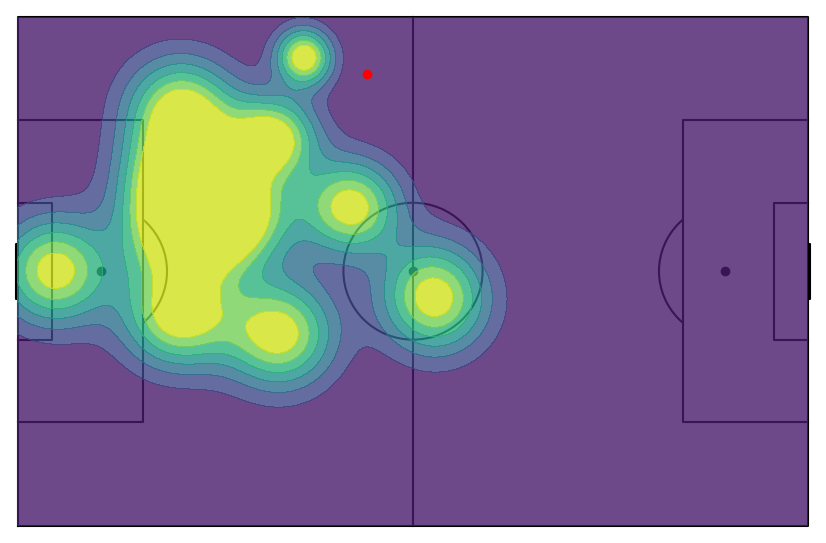

In [23]:
fig, ax = draw_pitch('white', 'black')

ax.contourf(x, y, d_kl.reshape(1040, 680), alpha=0.8)
ax.scatter(ball_x, ball_y, c='red')

(array([475153.,  31631.,  26678.,  22374.,  21763.,  21122.,  20120.,
         17071.,  16586.,  54702.]),
 array([6.96528443e-35, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

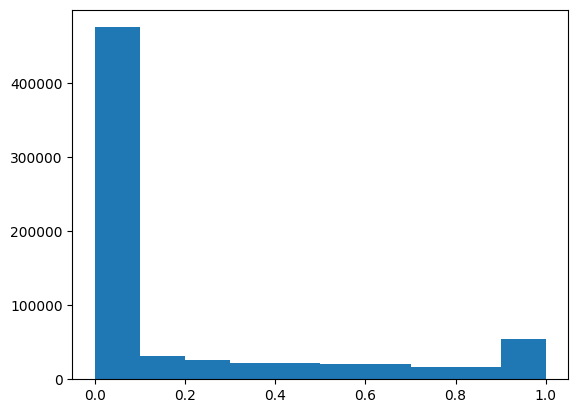

In [24]:
plt.hist(d_kl)

In [5]:
df = pd.read_json('./Data/sample_match_3_with_v.json')
e_df = pd.read_json('./Data/sample_Game_3_events.json')


In [6]:
e_df.head()

,event_id,event_type,result,success,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,set_piece_type,body_part_type
0,NaN,GENERIC:SET PIECE,None,NaN,1,14.44,NaN,alive,FIFATMA,FIFATMA,P3577,NaN,NaN,NaN,NaN,None,None,None
1,NaN,PASS,COMPLETE,1.0,1,14.44,15.08,alive,FIFATMA,FIFATMA,P3577,0.50125,0.48725,0.49864,0.48705,P3574,KICK_OFF,None
2,NaN,CARRY,COMPLETE,1.0,1,15.08,15.36,alive,FIFATMA,FIFATMA,P3574,0.49864,0.48705,0.49700,0.48500,None,None,None
3,NaN,PASS,COMPLETE,1.0,1,15.36,17.04,alive,FIFATMA,FIFATMA,P3574,0.49700,0.48500,0.63373,0.63449,P3575,None,None
4,NaN,CARRY,COMPLETE,1.0,1,17.04,18.60,alive,FIFATMA,FIFATMA,P3575,0.63373,0.63449,0.66986,0.59707,None,None,None
